In [1]:
pip install --upgrade kaggle

     |████████████████████████████████| 61kB 5.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=37b78dde9de6602f3c390b14caff54ceadf3b596ae7f3979f53e32608b366e2b
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [94]:
from google.colab import files

files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
#  ! kaggle datasets list

In [6]:
! kaggle competitions download -c dog-breed-identification

 97% 673M/691M [00:08<00:00, 49.5MB/s]
100% 691M/691M [00:08<00:00, 81.9MB/s]


In [7]:
! mkdir dogs_data

In [1]:
! unzip dog-breed-identification.zip -d dogs_data

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [10]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import cv2

In [11]:
labels_df=pd.read_csv('dogs_data/labels.csv')

In [12]:
labels_df.shape

(10222, 2)

In [13]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [14]:
selected_labels=['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever', 
 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound','tibetan_mastiff']

In [15]:
labels_df=labels_df[labels_df['breed'].isin(selected_labels)].reset_index(drop=True)

In [20]:
labels_df.breed.value_counts()

scottish_deerhound    126
beagle                105
pug                    94
saint_bernard          84
malamute               81
doberman               74
chihuahua              71
french_bulldog         70
tibetan_mastiff        69
golden_retriever       67
Name: breed, dtype: int64

In [16]:
n = len(labels_df)
breed = set(labels_df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

In [18]:
class_to_num

{'beagle': 3,
 'chihuahua': 9,
 'doberman': 1,
 'french_bulldog': 2,
 'golden_retriever': 6,
 'malamute': 0,
 'pug': 8,
 'saint_bernard': 4,
 'scottish_deerhound': 7,
 'tibetan_mastiff': 5}

In [17]:
num_to_class

{0: 'malamute',
 1: 'doberman',
 2: 'french_bulldog',
 3: 'beagle',
 4: 'saint_bernard',
 5: 'tibetan_mastiff',
 6: 'golden_retriever',
 7: 'scottish_deerhound',
 8: 'pug',
 9: 'chihuahua'}

In [21]:
size = 224
X_train = np.zeros((n, size, size, 3), dtype=np.uint8)
Y_train = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X_train[i] = cv2.resize(cv2.imread('dogs_data/train/%s.jpg' % labels_df['id'][i]), (size, size))
    Y_train[i][class_to_num[labels_df['breed'][i]]] = 1

100%|██████████| 841/841 [00:02<00:00, 305.86it/s]


In [22]:
X_train.shape

(841, 224, 224, 3)

In [23]:
Y_train.shape

(841, 10)

In [24]:
train_x, test_x, train_y, test_y = train_test_split(X_train, Y_train, test_size=0.15,  
                                                   stratify=Y_train, 
                                                   random_state=40, shuffle = True)

In [25]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.15,  
                                                  stratify=train_y, 
                                                  random_state=40, shuffle = True)

In [26]:
train_dataset= tf.keras.preprocessing.image.ImageDataGenerator().flow(train_x,train_y)
val_dataset  = tf.keras.preprocessing.image.ImageDataGenerator().flow(val_x,val_y)

In [27]:
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [28]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [29]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [30]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [31]:
base_model.trainable = False

In [32]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [33]:
prediction_layer = tf.keras.layers.Dense(len(selected_labels),activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [34]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [35]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [36]:
len(model.trainable_variables)

2

In [37]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_dataset)

4/4 [==============================] - 3s 238ms/step - loss: 2.8023 - accuracy: 0.0990


In [38]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.88
initial accuracy: 0.08


In [39]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/10
19/19 [==============================] - 6s 177ms/step - loss: 2.7919 - accuracy: 0.1106 - val_loss: 2.3802 - val_accuracy: 0.1481
Epoch 2/10
19/19 [==============================] - 2s 128ms/step - loss: 2.4483 - accuracy: 0.1782 - val_loss: 2.0936 - val_accuracy: 0.2593
Epoch 3/10
19/19 [==============================] - 2s 127ms/step - loss: 2.2511 - accuracy: 0.2277 - val_loss: 1.8511 - val_accuracy: 0.2870
Epoch 4/10
19/19 [==============================] - 2s 128ms/step - loss: 2.0406 - accuracy: 0.3119 - val_loss: 1.6274 - val_accuracy: 0.4167
Epoch 5/10
19/19 [==============================] - 2s 127ms/step - loss: 1.8156 - accuracy: 0.3746 - val_loss: 1.4439 - val_accuracy: 0.5278
Epoch 6/10
19/19 [==============================] - 2s 129ms/step - loss: 1.6971 - accuracy: 0.4142 - val_loss: 1.2896 - val_accuracy: 0.6204
Epoch 7/10
19/19 [==============================] - 2s 126ms/step - loss: 1.5010 - accuracy: 0.5182 - val_loss: 1.1532 - val_accuracy: 0.6944
Epoch 

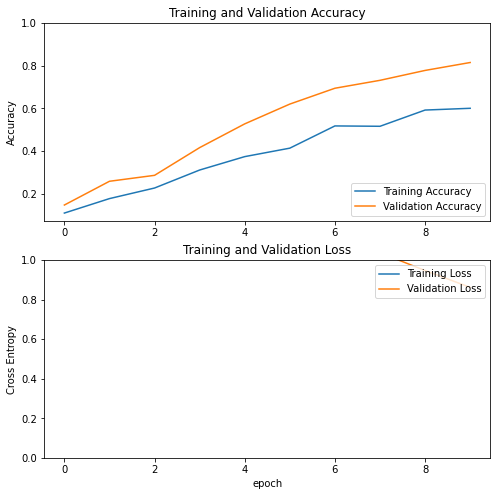

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Now, let's fine tune last 75 layers to improve our model

In [41]:
base_model.trainable = True

In [42]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [43]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [44]:
len(model.trainable_variables)

92

In [45]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 10/30
19/19 [==============================] - 11s 280ms/step - loss: 1.0421 - accuracy: 0.6488 - val_loss: 0.3728 - val_accuracy: 0.8889
Epoch 11/30
19/19 [==============================] - 4s 205ms/step - loss: 0.6497 - accuracy: 0.7812 - val_loss: 0.3025 - val_accuracy: 0.9074
Epoch 12/30
19/19 [==============================] - 4s 205ms/step - loss: 0.5215 - accuracy: 0.8201 - val_loss: 0.2214 - val_accuracy: 0.9444
Epoch 13/30
19/19 [==============================] - 4s 207ms/step - loss: 0.3610 - accuracy: 0.8669 - val_loss: 0.1901 - val_accuracy: 0.9630
Epoch 14/30
19/19 [==============================] - 4s 207ms/step - loss: 0.3757 - accuracy: 0.8816 - val_loss: 0.1685 - val_accuracy: 0.9537
Epoch 15/30
19/19 [==============================] - 4s 208ms/step - loss: 0.2712 - accuracy: 0.9043 - val_loss: 0.1920 - val_accuracy: 0.9630
Epoch 16/30
19/19 [==============================] - 4s 207ms/step - loss: 0.2379 - accuracy: 0.9167 - val_loss: 0.1464 - val_accuracy: 0.953

In [46]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

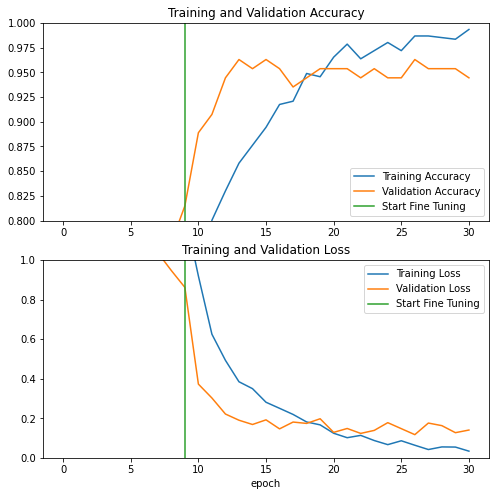

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:
model.evaluate(test_x,test_y)

4/4 [==============================] - 2s 326ms/step - loss: 0.3826 - accuracy: 0.8819


[0.3826220631599426, 0.8818897604942322]

In [49]:
predictions=np.argmax(model.predict(test_x),axis=1)

In [65]:
labels=np.argmax(test_y,axis=1)

In [67]:
tf.math.confusion_matrix(labels,predictions)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[12,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  0,  0,  0,  0,  1,  1],
       [ 0,  0,  0, 15,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, 11,  1,  0,  0,  1,  0],
       [ 1,  0,  0,  0,  0,  7,  1,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0, 17,  1,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 13,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  1,  1,  7]], dtype=int32)>

In [68]:
from sklearn.metrics import f1_score, roc_auc_score

In [69]:
f1_score(labels,predictions,average='macro')

0.8753202909474593

In [70]:
roc_auc_score(test_y,model.predict(test_x),multi_class='ovo')

0.9963660609526533

In [71]:
model.save('model/dog_classifier_model')

INFO:tensorflow:Assets written to: model/dog_classifier_model/assets


In [72]:
!zip -r /content/model.zip /content/model/dog_classifier_model

  adding: content/model/dog_classifier_model/ (stored 0%)
  adding: content/model/dog_classifier_model/saved_model.pb (deflated 93%)
  adding: content/model/dog_classifier_model/assets/ (stored 0%)
  adding: content/model/dog_classifier_model/variables/ (stored 0%)
  adding: content/model/dog_classifier_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model/dog_classifier_model/variables/variables.index (deflated 80%)


In [73]:
files.download("/content/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
model.save('dog_classifier_model.h5')